In [1]:
from pathlib import Path
import pandas as pd
from matplotlib import pyplot as plt
import mplhep as hep
import numpy as np

hep.style.use(hep.style.CMS)

In [2]:
lumi_dict = {
    "2022": 7.9714,
    "2022EE": 26.337,
    "2023": 17.981,
    "2023BPix": 9.516,
}

In [22]:
eras = ["2022", "2022EE", "2023BPix", "2023"]
dir_original = Path("events")  # with btag weight
dir_modified = Path("events_mod") # without btag weight

weight_dict = {}
# weight_key = "trigger_weight"
weight_key = "weight"

for era in eras:
    era_dict = {}
    path = dir_original / Path(f"processed_events_{era}.pkl")
    if path.exists():
        df_dict = pd.read_pickle(path)
    else:
        print(f"File {path} not found")
        continue
    for signal_type in df_dict.keys():
        if signal_type == "data":
            continue
        df = df_dict[signal_type]
        weight = df[weight_key].to_numpy()
        era_dict[signal_type] = {"original": weight}
        
    path = dir_modified / Path(f"processed_events_{era}.pkl")
    if path.exists():
        df_dict = pd.read_pickle(path)
    else:
        print(f"File {path} not found")
        continue
    for signal_type in df_dict.keys():
        if signal_type == "data":
            continue
        df = df_dict[signal_type]
        weight = df[weight_key].to_numpy()
        era_dict[signal_type]["modified"] = weight
    
    weight_dict[era] = era_dict
        

In [23]:
hh4b_keys = [signal_type for signal_type in weight_dict["2022"].keys() if "hh4b" in signal_type]
hh4b_weight_dict = {}

for era in eras:
    if era not in weight_dict:
        continue
        
    original_weight = []
    modified_weight = []
    
    for signal_type in hh4b_keys:
        if signal_type in weight_dict[era]:
            # Concatenate original weight values
            if "original" in weight_dict[era][signal_type]:
                original_weight.append(weight_dict[era][signal_type]["original"])
            
            # Concatenate modified weight values
            if "modified" in weight_dict[era][signal_type]:
                modified_weight.append(weight_dict[era][signal_type]["modified"])
    
    # Combine all arrays for this era
    if original_weight:  # Check if list is not empty
        hh4b_weight_dict[era] = {
            "original": np.concatenate(original_weight),
            "modified": np.concatenate(modified_weight) if modified_weight else None
        }

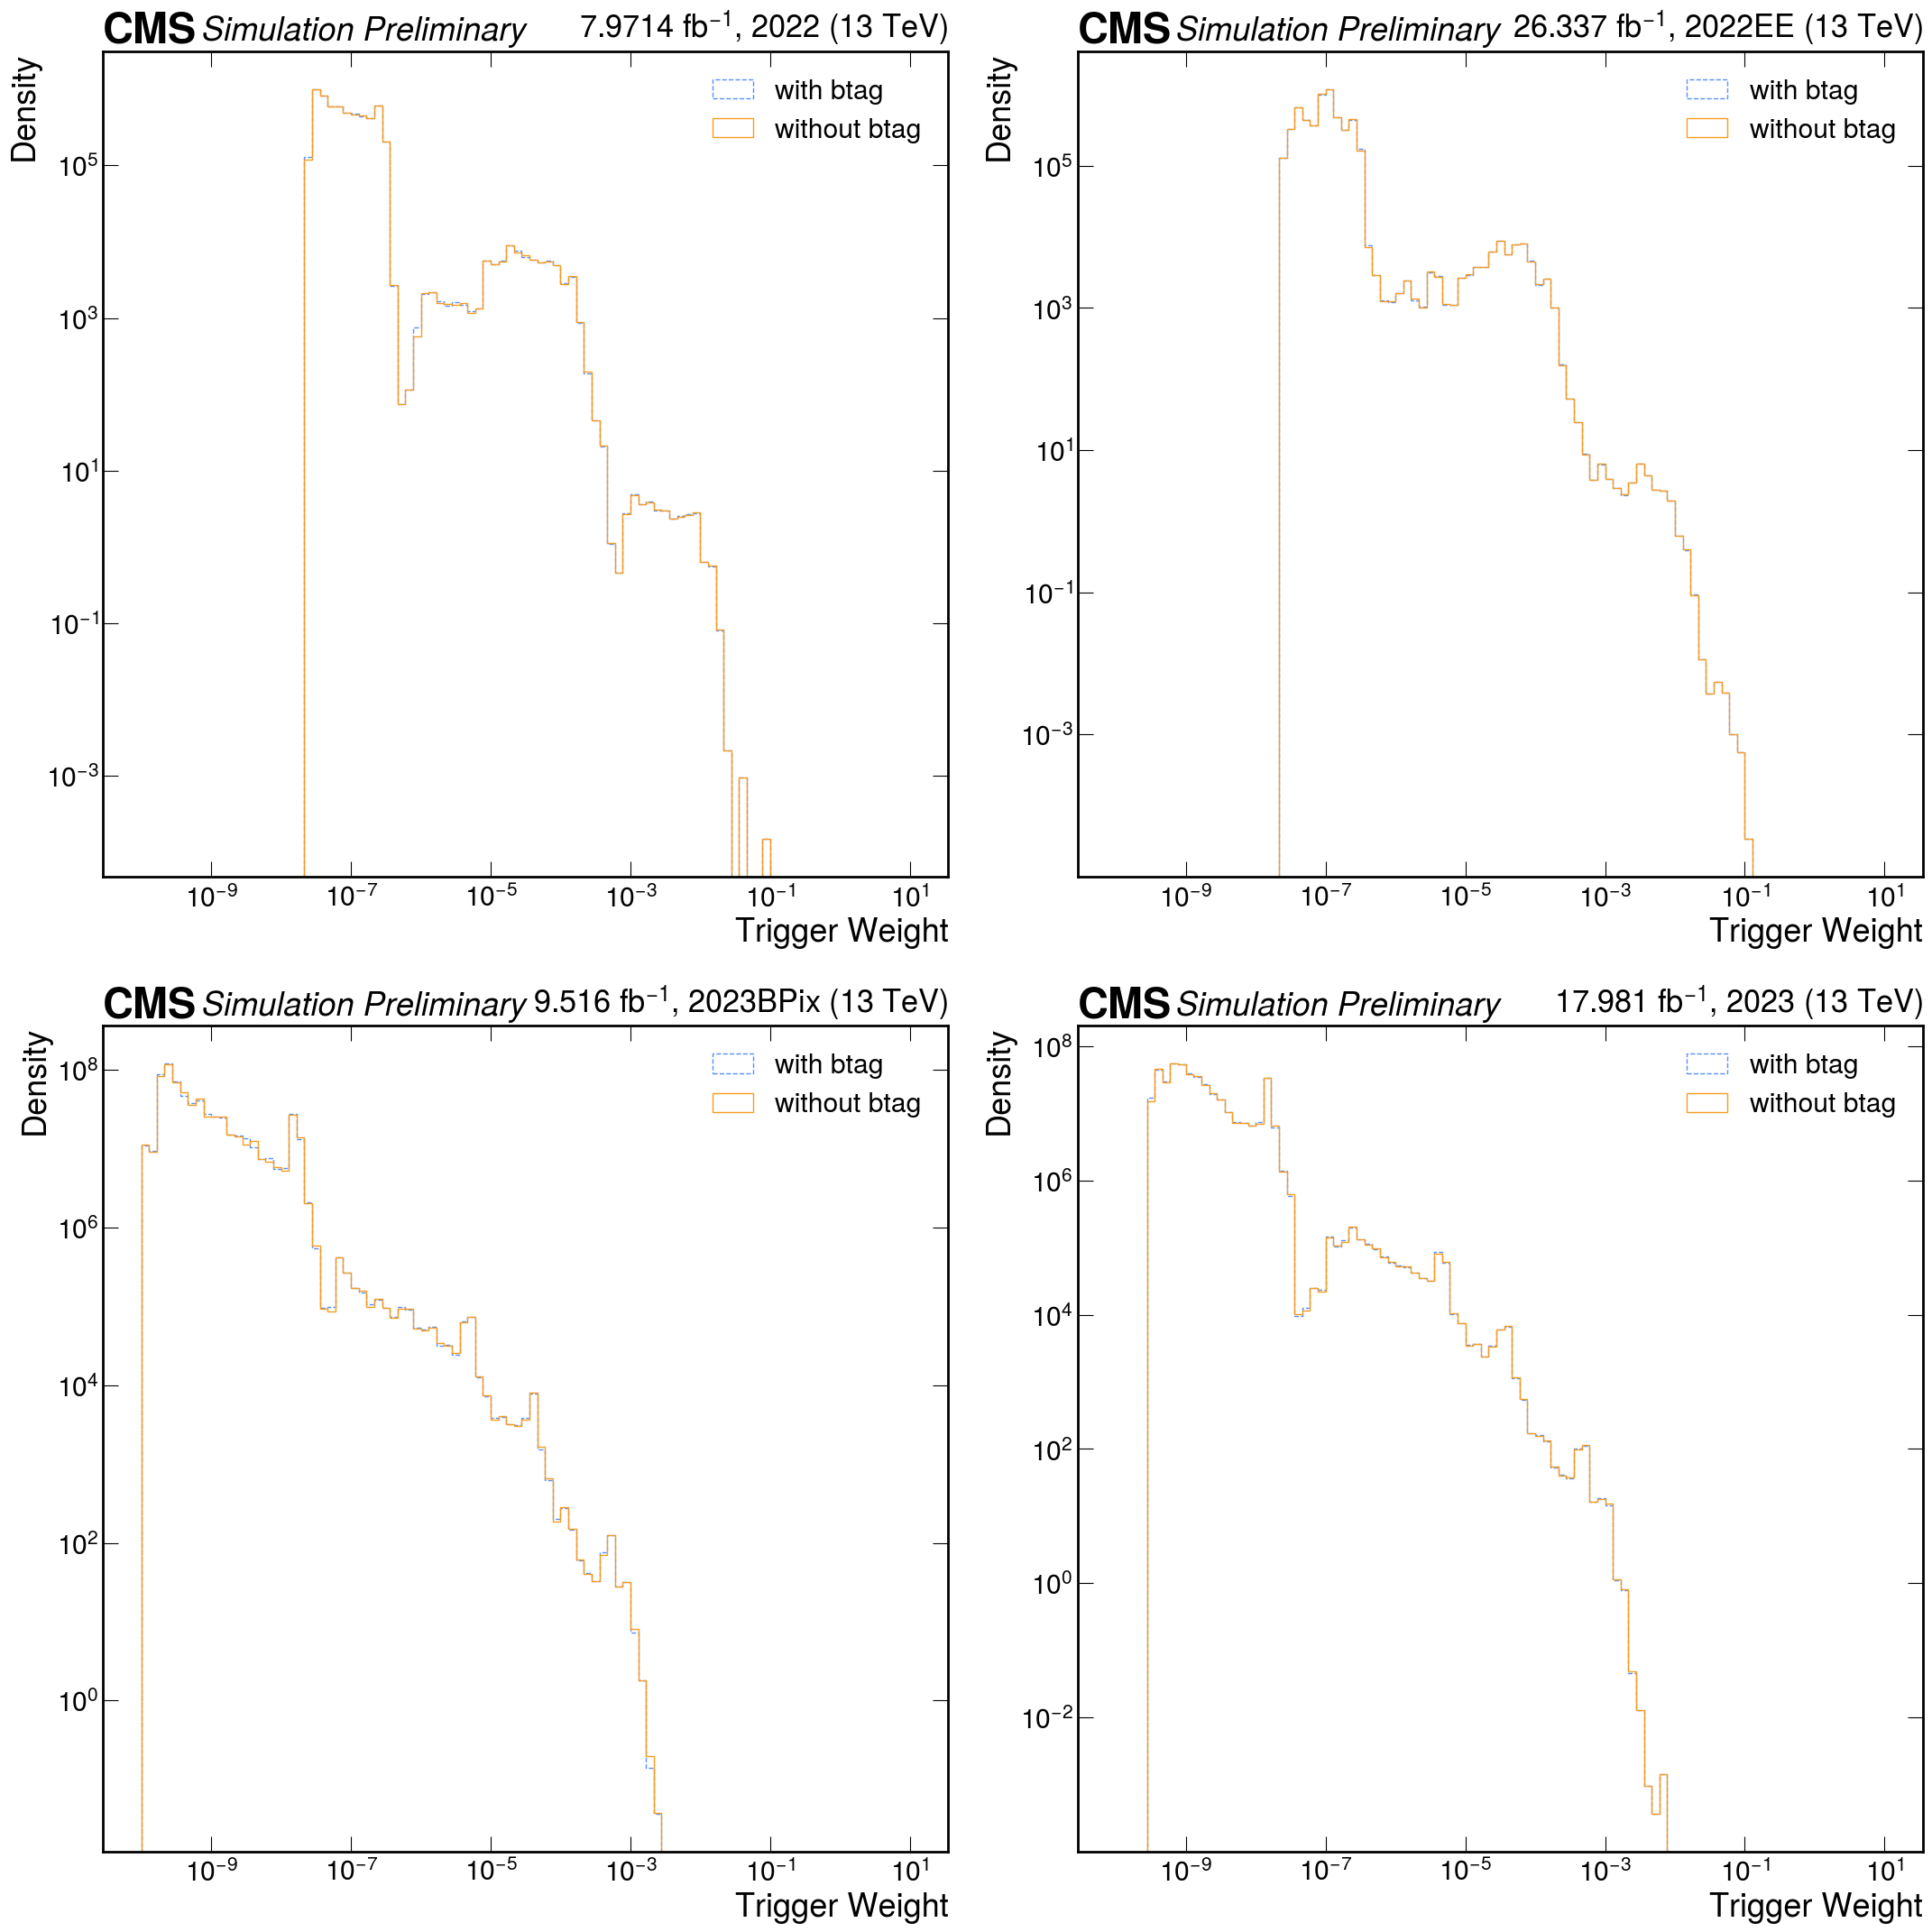

In [24]:
density = True
fig, axs = plt.subplots(2, 2, figsize=(22, 22))

for idx, era in enumerate(eras):
    i, j = idx // 2, idx % 2
    ax = axs[i, j]
    
    weights_original = hh4b_weight_dict[era]["original"]
    weights_modified = hh4b_weight_dict[era]["modified"]
    
    if weight_key == "trigger_weight":
        bins = np.linspace(0.5, 1.5, 80)
    elif weight_key == "weight":
        ax.set_xscale("log")
        bins = np.logspace(-10, 1, 100)
    
    ax.hist(weights_original, bins=bins, histtype="step", label="with btag", density=density, linestyle="--")
    ax.hist(weights_modified, bins=bins, histtype="step", label="without btag", density=density)
    
    lumi = lumi_dict[era]
    hep.cms.label("Preliminary", ax=ax, lumi=lumi, year=era)
    
    ax.set_xlabel("Trigger Weight")
    ax.set_ylabel("Density")
    ax.set_yscale("log")
    ax.legend()
    
plt.tight_layout()
plt.savefig(f"weight_comparison_{weight_key}.pdf")
plt.show()